In [1]:
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Setup numeric representation of transitions and values

In [2]:
sentiment_to_numeric = {"negative": 3,  "neutral": 5,  "positive": 9}
# numeric_to_sentiment = {3: "negative",  5: "neutral",  9: "positive"}
numeric_to_echo_transitions = {3: "negative_to_negative",  5: "neutral_to_neutral",  9: "positive_to_positive"}

In [3]:
nr_diffs = []
for ustr in sentiment_to_numeric.keys():
    uval = sentiment_to_numeric[ustr]
    for vstr in sentiment_to_numeric.keys():
        vval = sentiment_to_numeric[vstr]
        if ustr == vstr:
            continue
        nr_diffs.append([uval - vval, uval, vval, ustr, vstr, f"{ustr}_to_{vstr}"])
nr_diffs = pd.DataFrame(nr_diffs, columns=["fdiff", "from", "to", "from_str", "to_str", "transition"])
nr_diffs

,fdiff,from,to,from_str,to_str,transition
0,-2,3,5,negative,neutral,negative_to_neutral
1,-6,3,9,negative,positive,negative_to_positive
2,2,5,3,neutral,negative,neutral_to_negative
3,-4,5,9,neutral,positive,neutral_to_positive
4,6,9,3,positive,negative,positive_to_negative
5,4,9,5,positive,neutral,positive_to_neutral


In [4]:
fdiff_to_transition = nr_diffs.set_index("fdiff")["transition"].to_dict()

## 2. Read data and validate Sentiment values

In [5]:
datadf = pd.read_csv("C:/Users/pog66/Downloads/full_isarel_112top_users.csv", parse_dates=["Date"], usecols=["Date", "Author", "Sentiment"])
datadf.sort_values("Date", inplace=True)
datadf

,Date,Author,Sentiment
35257,2023-10-06 03:24:40,ArtVandelay2021,negative
35256,2023-10-06 04:45:07,Reuters,neutral
35255,2023-10-06 06:21:36,ArtVandelay2021,negative
35254,2023-10-06 07:02:33,realTuckFrumper,neutral
35253,2023-10-06 07:03:03,BrettDGilman,neutral
...,...,...,...
4,2023-10-20 23:57:37,dcexaminer,negative
3,2023-10-20 23:58:06,BaronianConsult,neutral
2,2023-10-20 23:58:21,BaronianConsult,negative
1,2023-10-20 23:58:55,BaronianConsult,neutral


### 2.2. Filter the SENTIMENTS ( e.g. remove Positive sentiment )

In [6]:
# # remove positive sentiment for now by removing all authors who have positive sentiments
# positive_authors = set(datadf[datadf["Sentiment"] == "positive"]["Author"].unique())
# datadf.drop(datadf[datadf["Author"].isin(positive_authors)].index, inplace=True)
# datadf

In [7]:
# this value will be used for file name and column name identification for calculations of marginal values
num_sentiments = datadf["Sentiment"].nunique()
sentiments = "_".join(sorted(datadf["Sentiment"].unique()))
sentiment_titles = ", ".join(sorted(datadf["Sentiment"].unique()))
sentiments

'negative_neutral_positive'

In [8]:
if not os.path.exists("./outputs") or not os.path.isdir("./outputs"):
    os.mkdir("./outputs")
    
output_dir = f"./outputs/{sentiments}"
if not os.path.exists(output_dir) or not os.path.isdir(output_dir):
    os.mkdir(output_dir)

output_figures_dir = f"{output_dir}/figures"
if not os.path.exists(output_figures_dir) or not os.path.isdir(output_figures_dir):
    os.mkdir(output_figures_dir)

output_dir, output_figures_dir

('./outputs/negative_neutral_positive',
 './outputs/negative_neutral_positive/figures')

In [9]:
datadf["NumericSentiment"] = datadf["Sentiment"].apply(lambda x: sentiment_to_numeric[x])
datadf

,Date,Author,Sentiment,NumericSentiment
35257,2023-10-06 03:24:40,ArtVandelay2021,negative,3
35256,2023-10-06 04:45:07,Reuters,neutral,5
35255,2023-10-06 06:21:36,ArtVandelay2021,negative,3
35254,2023-10-06 07:02:33,realTuckFrumper,neutral,5
35253,2023-10-06 07:03:03,BrettDGilman,neutral,5
...,...,...,...,...
4,2023-10-20 23:57:37,dcexaminer,negative,3
3,2023-10-20 23:58:06,BaronianConsult,neutral,5
2,2023-10-20 23:58:21,BaronianConsult,negative,3
1,2023-10-20 23:58:55,BaronianConsult,neutral,5


## 3. Calculate Average Transition Delay

In [10]:
def group_calc_delay(df):
    df["Transitions"] = df["NumericSentiment"].diff()
    df["Trans"] = df[["NumericSentiment", "Transitions"]].apply(lambda row: fdiff_to_transition[row["Transitions"]] if row["Transitions"] in fdiff_to_transition else numeric_to_echo_transitions[row["NumericSentiment"]], axis=1)
    df["Delay"] = df["Date"].diff().apply(lambda x: x.total_seconds())
    rdf = df[["Trans", "Delay"]].groupby("Trans").mean()
    return rdf

In [11]:
time_calcs = datadf[["Author", "NumericSentiment", "Date"]].groupby("Author").apply(lambda gdf: group_calc_delay(gdf)).reset_index()
time_calcs

,Author,Trans,Delay
0,2023Jamesthai,negative_to_negative,2525.590909
1,2023Jamesthai,negative_to_neutral,4508.357143
2,2023Jamesthai,neutral_to_negative,5419.168675
3,2023Jamesthai,neutral_to_neutral,1790.338028
4,AHRCUSA,negative_to_negative,5606.565789
...,...,...,...
567,xoxnews,positive_to_neutral,767.000000
568,zerohedge,negative_to_negative,11140.500000
569,zerohedge,negative_to_neutral,18817.222222
570,zerohedge,neutral_to_negative,22204.222222


In [12]:
avg_trans_delay = time_calcs.pivot(index="Author", columns="Trans", values="Delay") / 3600
avg_trans_delay.to_csv(f"{output_dir}/avg_transition_delay_{sentiments}.csv")
avg_trans_delay

Trans,negative_to_negative,negative_to_neutral,negative_to_positive,neutral_to_negative,neutral_to_neutral,neutral_to_positive,positive_to_negative,positive_to_neutral,positive_to_positive
Author,,,,,,,,,
2023Jamesthai,0.701553,1.252321,NaN,1.505325,0.497316,NaN,NaN,NaN,NaN
AHRCUSA,1.557379,1.238980,NaN,1.471935,0.936190,NaN,NaN,NaN,NaN
AJEnglish,1.005588,0.805479,NaN,0.962485,0.678979,NaN,NaN,NaN,NaN
AP,3.772457,3.623135,NaN,3.232348,2.924268,NaN,NaN,NaN,NaN
AndyVermaut,0.524815,0.491026,NaN,0.427157,0.510971,0.408333,NaN,0.024444,NaN
...,...,...,...,...,...,...,...,...,...
ultradeadd,0.570342,1.111328,NaN,1.117653,0.847636,NaN,NaN,NaN,NaN
washingtonpost,1.912222,2.235688,NaN,1.907926,1.480795,NaN,NaN,NaN,NaN
worldcotrader,NaN,NaN,NaN,NaN,0.018225,NaN,NaN,NaN,NaN


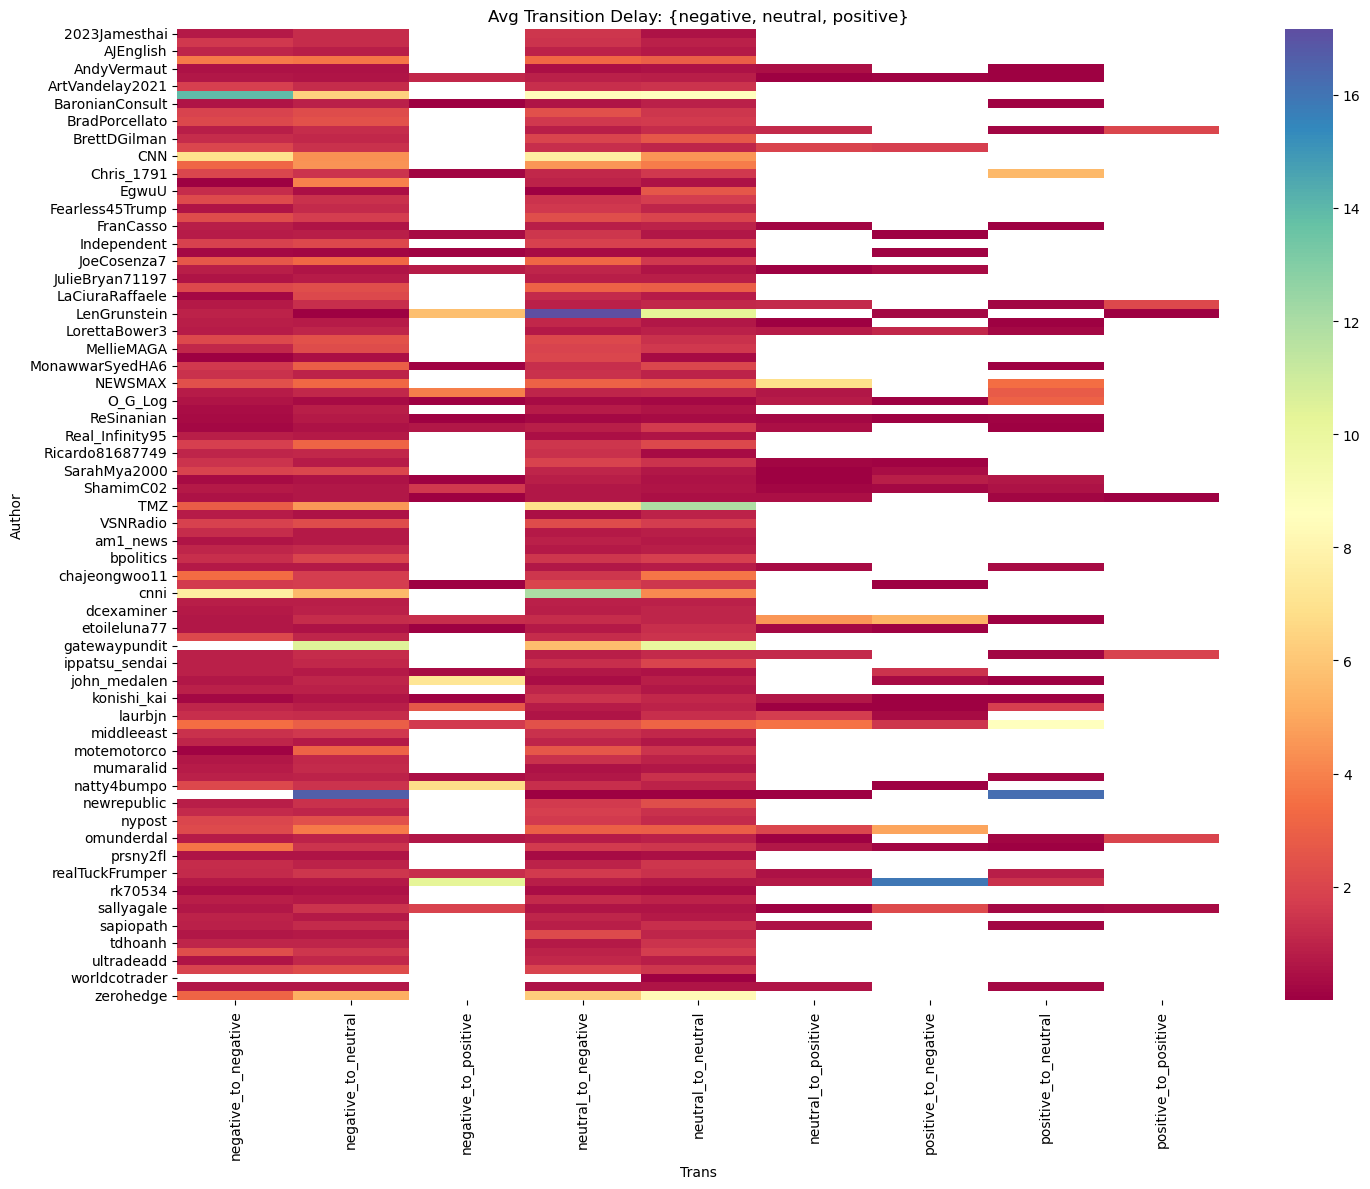

In [13]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(avg_trans_delay, cmap=sns.color_palette("Spectral", as_cmap=True))
plt.title(f"Avg Transition Delay: {{{sentiment_titles}}}")
plt.tight_layout()
plt.savefig(f"{output_figures_dir}/Average_Transition_Delay_Heatmap_{sentiments}.png")
plt.show()

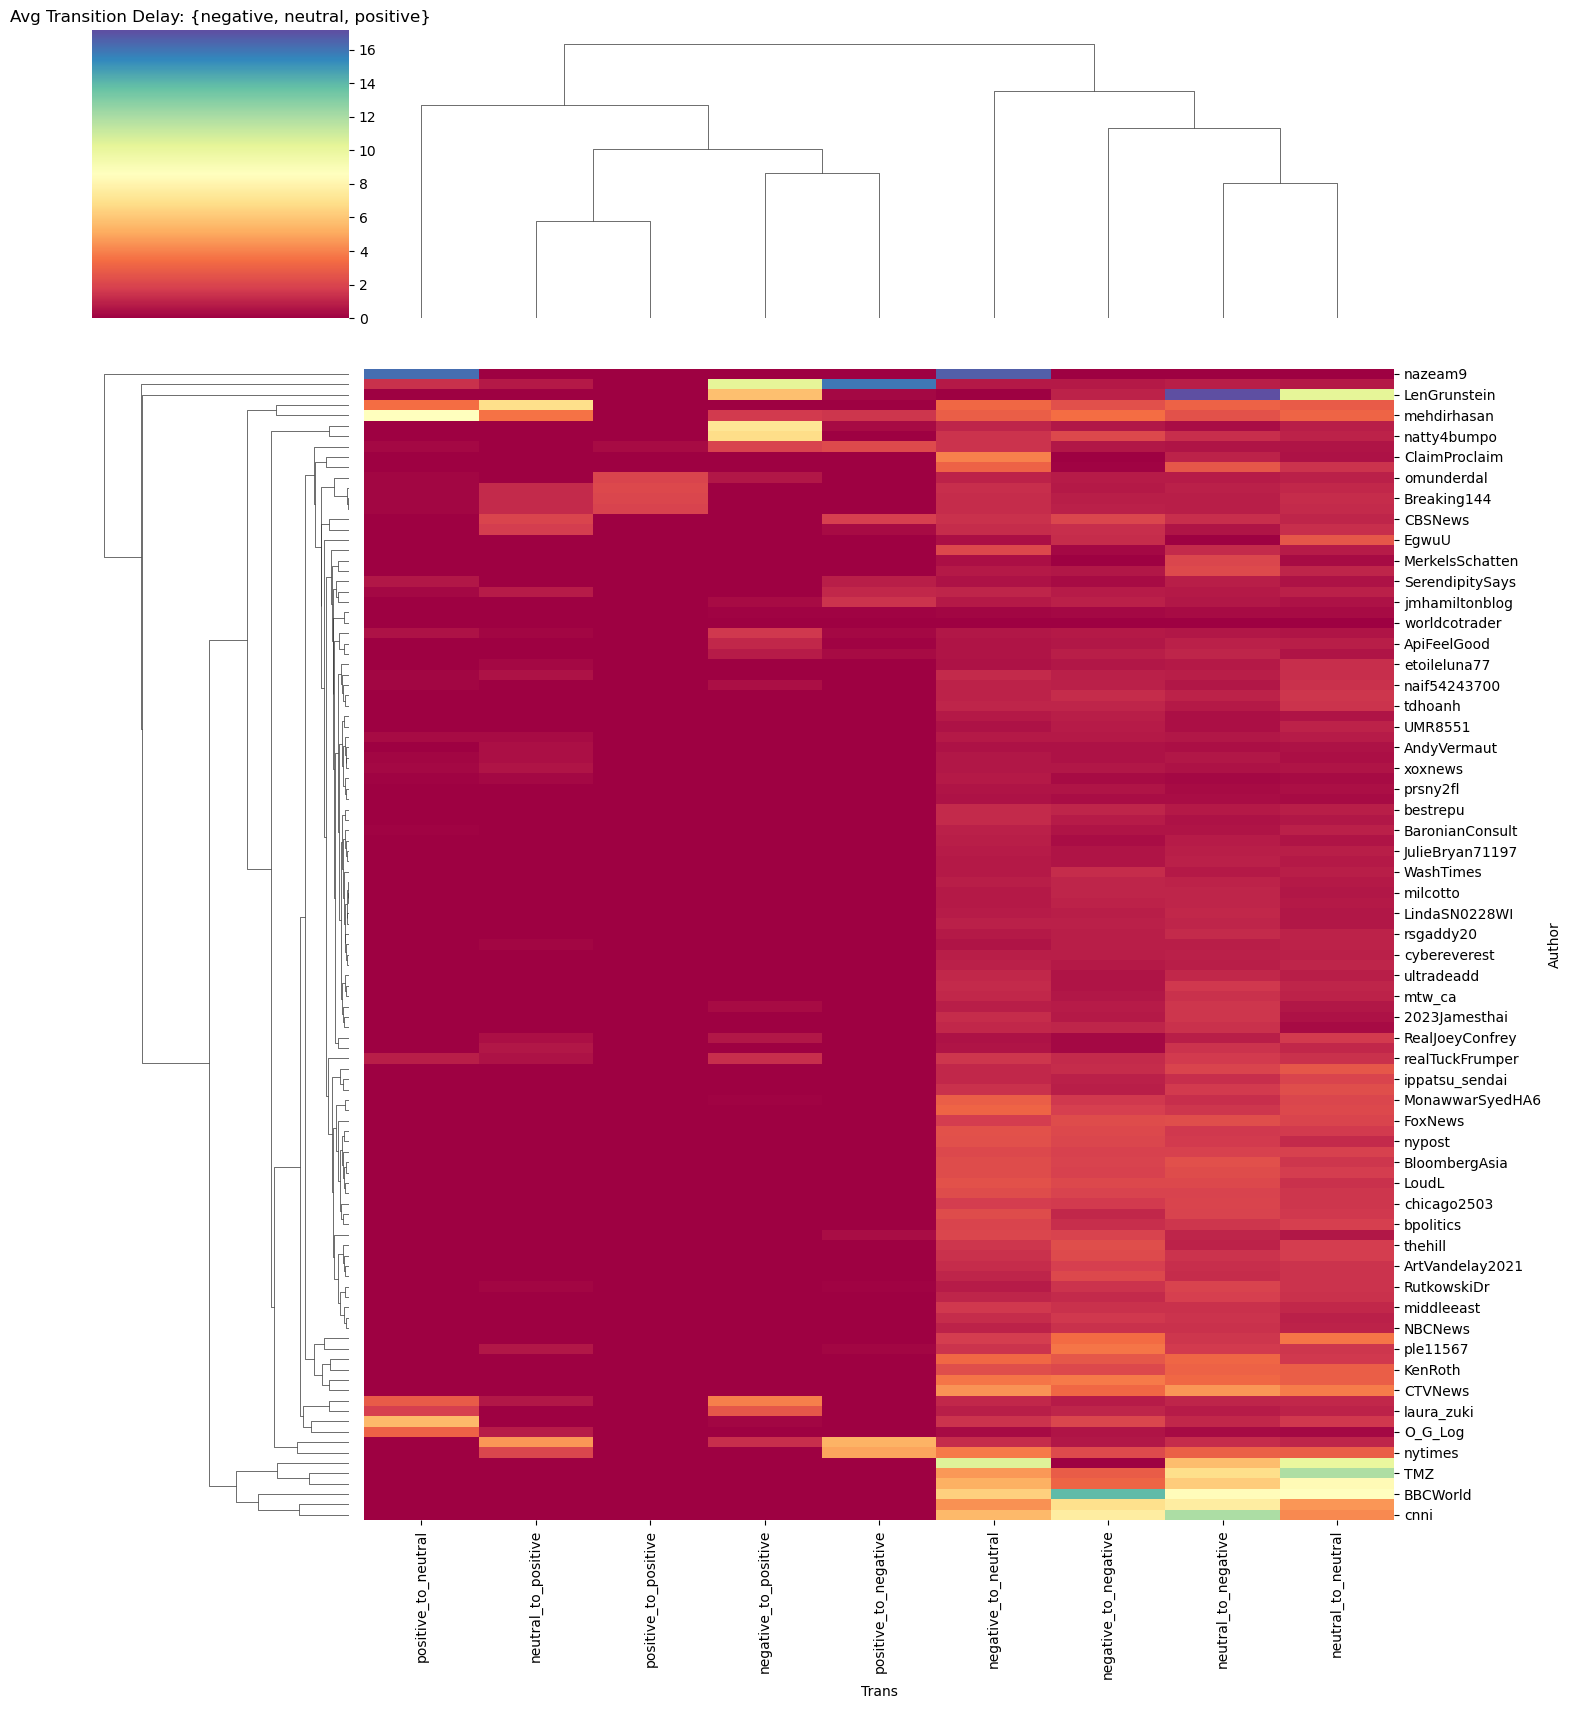

In [14]:
sns.clustermap(avg_trans_delay.fillna(0), figsize=(15,17), cmap=sns.color_palette("Spectral", as_cmap=True))
plt.title(f"Avg Transition Delay: {{{sentiment_titles}}}")
plt.tight_layout()
plt.savefig(f"{output_figures_dir}/Average_Transition_Delay_Clusterplot_{sentiments}.png")
plt.show()

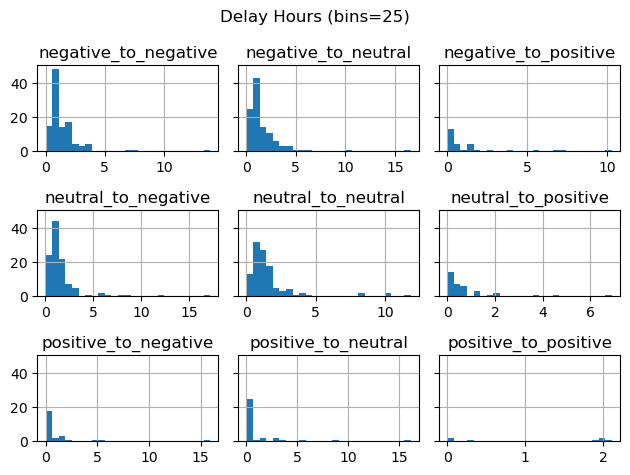

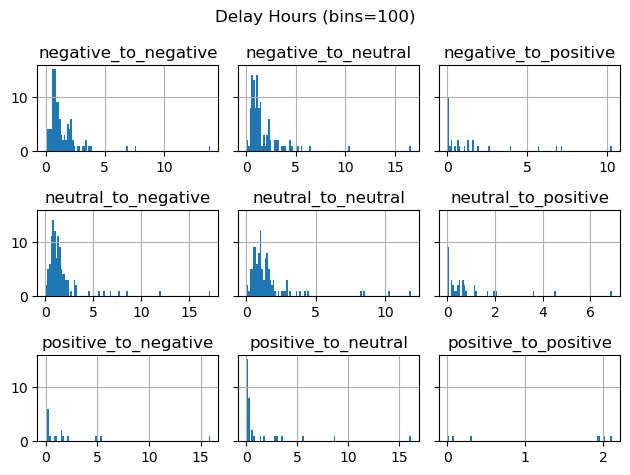

In [15]:
for binv in [25, 100]:
    fig, axs = plt.subplots(num_sentiments, num_sentiments, sharey=True)
    for idx, col in enumerate(avg_trans_delay.columns):
        y = idx % num_sentiments
        x = idx // num_sentiments
        avg_trans_delay[col].hist(bins=binv, ax=axs[x][y])
        axs[x][y].set_title(col)

    plt.suptitle(f"Delay Hours (bins={binv})")
    plt.tight_layout()
    plt.savefig(f"{output_figures_dir}/DelayHoursHistograms_{sentiments}_bins{binv}.png")
    plt.show()

## 4. Calculate Marginal Probability

In [16]:
def gcalc(df):
    df["Transitions"] = df["NumericSentiment"].diff()
    df["Trans"] = df[["NumericSentiment", "Transitions"]].apply(lambda row: fdiff_to_transition[row["Transitions"]] if row["Transitions"] in fdiff_to_transition else numeric_to_echo_transitions[row["NumericSentiment"]], axis=1)
    df.dropna(inplace=True)
    return df["Trans"].value_counts().rename("val").rename_axis("Trans") / df.shape[0]

In [17]:
gcalcs = datadf[["Author", "NumericSentiment"]].groupby("Author").apply(lambda gdf: gcalc(gdf)).reset_index()
gcalcs

,Author,Trans,val
0,2023Jamesthai,neutral_to_neutral,0.378667
1,2023Jamesthai,negative_to_neutral,0.224000
2,2023Jamesthai,neutral_to_negative,0.221333
3,2023Jamesthai,negative_to_negative,0.176000
4,AHRCUSA,negative_to_negative,0.314050
...,...,...,...
567,xoxnews,neutral_to_positive,0.001808
568,zerohedge,neutral_to_neutral,0.534884
569,zerohedge,negative_to_neutral,0.209302
570,zerohedge,neutral_to_negative,0.209302


In [18]:
gcalcs = gcalcs.pivot(index="Author", columns="Trans", values="val")
gcalcs.to_csv(f"{output_dir}/gcalcs_{sentiments}.csv")
gcalcs

Trans,negative_to_negative,negative_to_neutral,negative_to_positive,neutral_to_negative,neutral_to_neutral,neutral_to_positive,positive_to_negative,positive_to_neutral,positive_to_positive
Author,,,,,,,,,
2023Jamesthai,0.176000,0.224000,NaN,0.221333,0.378667,NaN,NaN,NaN,NaN
AHRCUSA,0.314050,0.239669,NaN,0.243802,0.202479,NaN,NaN,NaN,NaN
AJEnglish,0.139535,0.218605,NaN,0.218605,0.423256,NaN,NaN,NaN,NaN
AP,0.419355,0.225806,NaN,0.236559,0.118280,NaN,NaN,NaN,NaN
AndyVermaut,0.022590,0.128012,NaN,0.128012,0.718373,0.001506,NaN,0.001506,NaN
...,...,...,...,...,...,...,...,...,...
ultradeadd,0.194366,0.191549,NaN,0.188732,0.425352,NaN,NaN,NaN,NaN
washingtonpost,0.222222,0.257310,NaN,0.263158,0.257310,NaN,NaN,NaN,NaN
worldcotrader,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN


In [19]:
marginal_df = pd.DataFrame()
for sntmnt in sentiments.split("_"):
    cols = [col for col in gcalcs.columns if col.split("_")[0] == sntmnt]
    sum_val = gcalcs[cols].sum(axis=1).rename(f"{sntmnt}_sum")
    marginal_df = marginal_df.join( gcalcs[cols].div(sum_val, axis=0), how="outer")

marginal_df

,negative_to_negative,negative_to_neutral,negative_to_positive,neutral_to_negative,neutral_to_neutral,neutral_to_positive,positive_to_negative,positive_to_neutral,positive_to_positive
Author,,,,,,,,,
2023Jamesthai,0.440000,0.560000,NaN,0.368889,0.631111,NaN,NaN,NaN,NaN
AHRCUSA,0.567164,0.432836,NaN,0.546296,0.453704,NaN,NaN,NaN,NaN
AJEnglish,0.389610,0.610390,NaN,0.340580,0.659420,NaN,NaN,NaN,NaN
AP,0.650000,0.350000,NaN,0.666667,0.333333,NaN,NaN,NaN,NaN
AndyVermaut,0.150000,0.850000,NaN,0.150977,0.847247,0.001776,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...
ultradeadd,0.503650,0.496350,NaN,0.307339,0.692661,NaN,NaN,NaN,NaN
washingtonpost,0.463415,0.536585,NaN,0.505618,0.494382,NaN,NaN,NaN,NaN
worldcotrader,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN


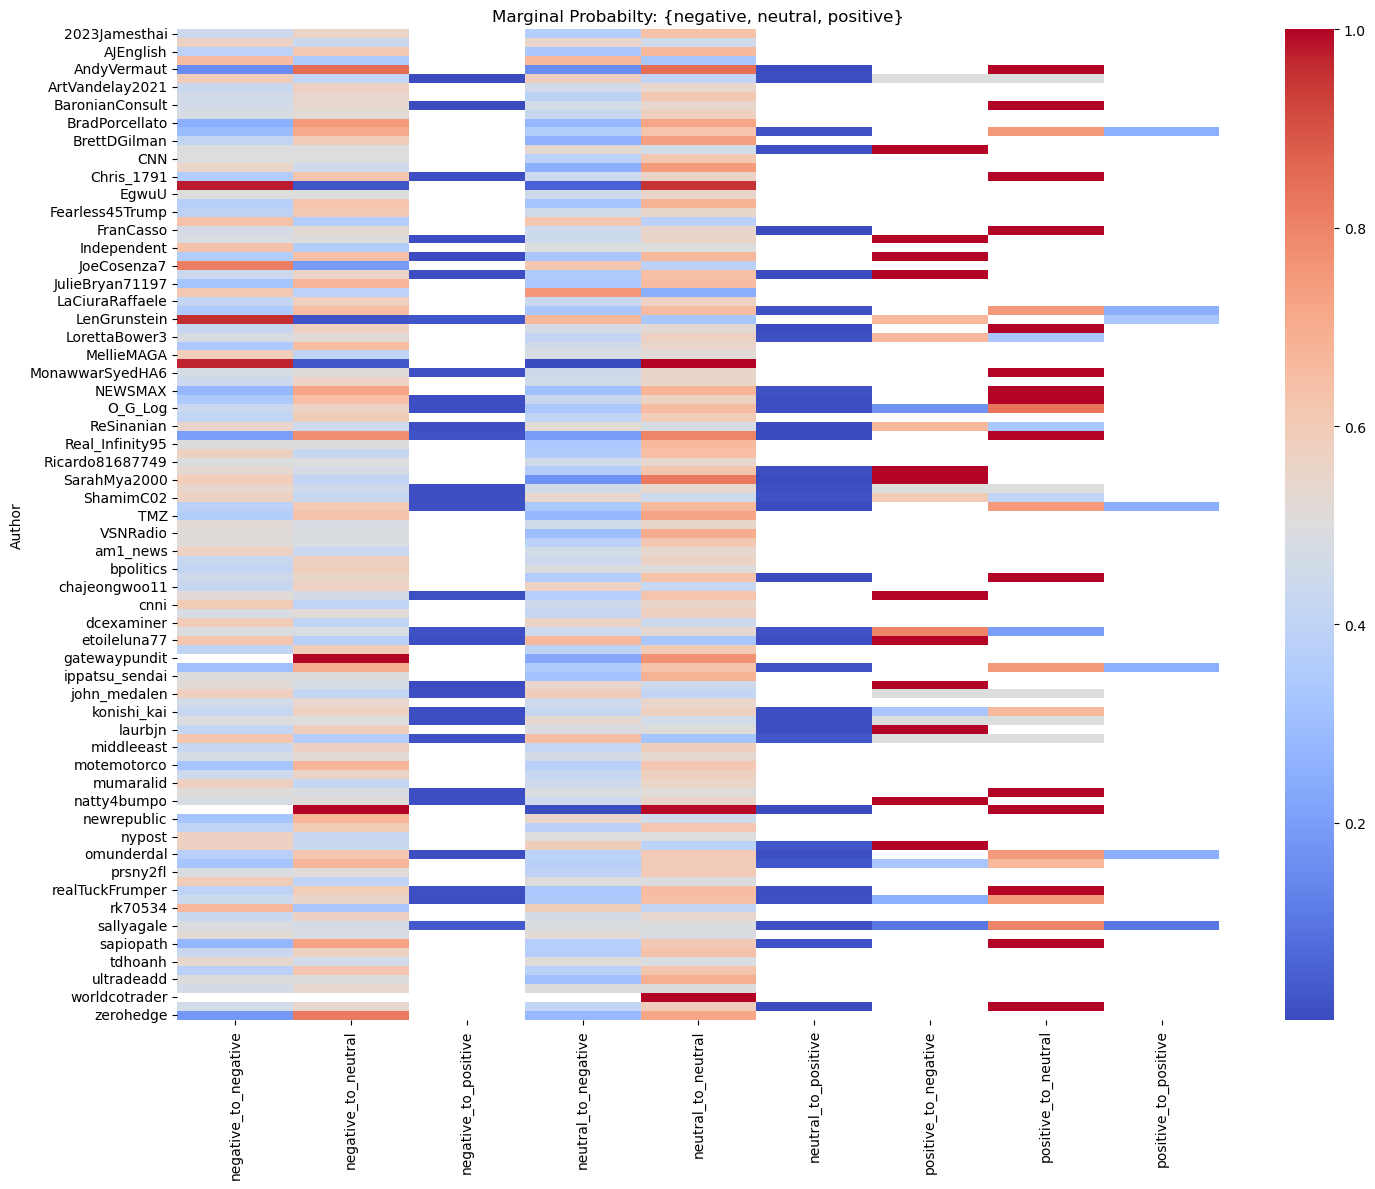

In [20]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(marginal_df, cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.title(f"Marginal Probabilty: {{{sentiment_titles}}}")
plt.tight_layout()
plt.savefig(f"{output_figures_dir}/Marginal_Probability_Heatmap_{sentiments}.png")
plt.show()

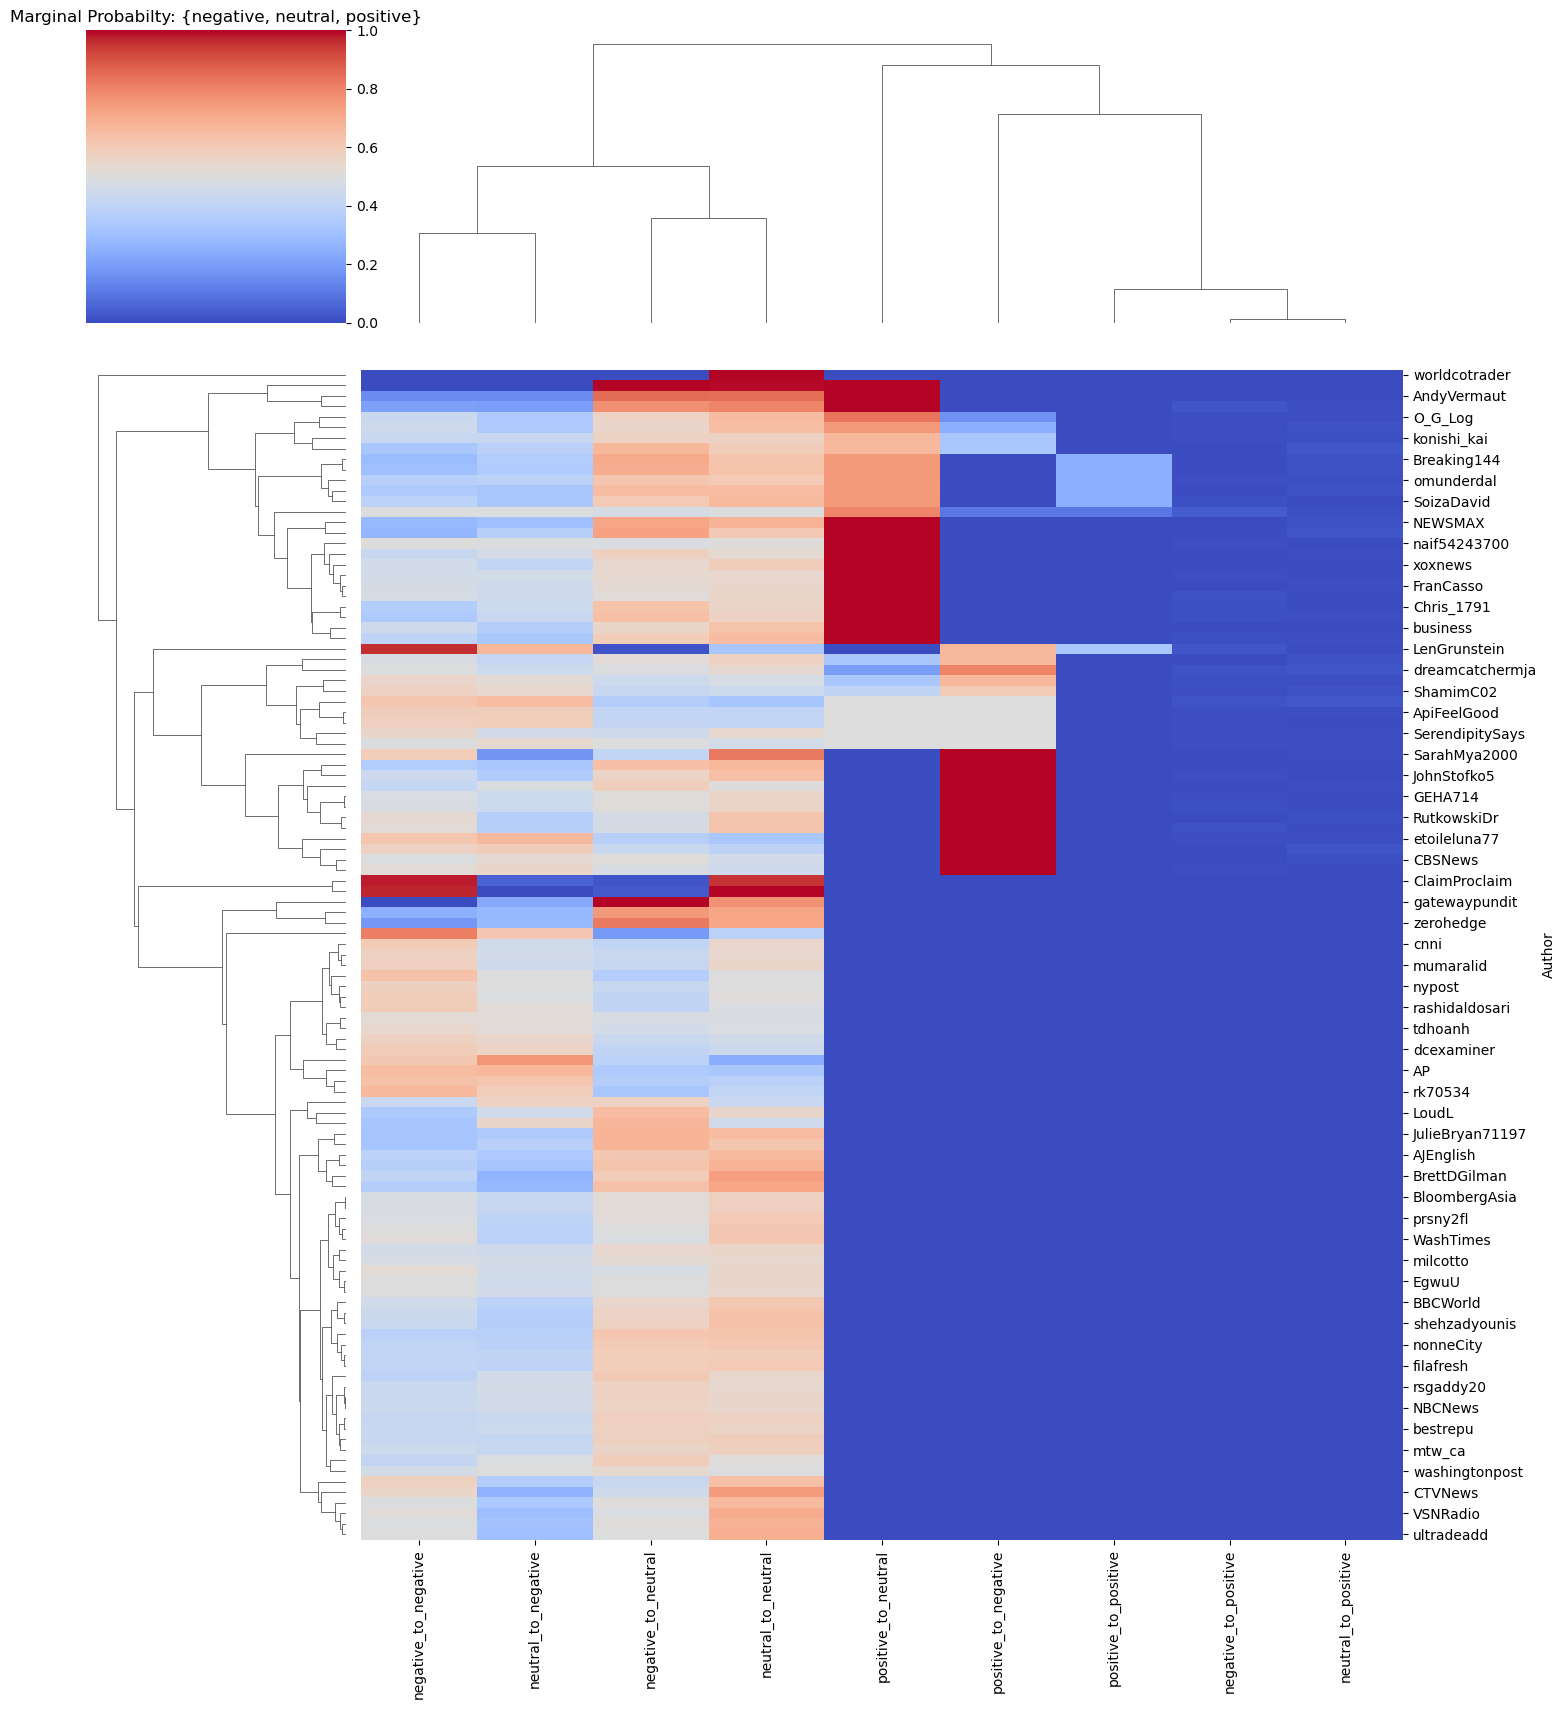

In [21]:
# fig, ax = plt.subplots(figsize=(15,12))
sns.clustermap(marginal_df.fillna(0), figsize=(15,17), cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.title(f"Marginal Probabilty: {{{sentiment_titles}}}")
plt.tight_layout()
plt.savefig(f"{output_figures_dir}/Marginal_Probability_Clusterplot_cw_{sentiments}.png")
plt.show()

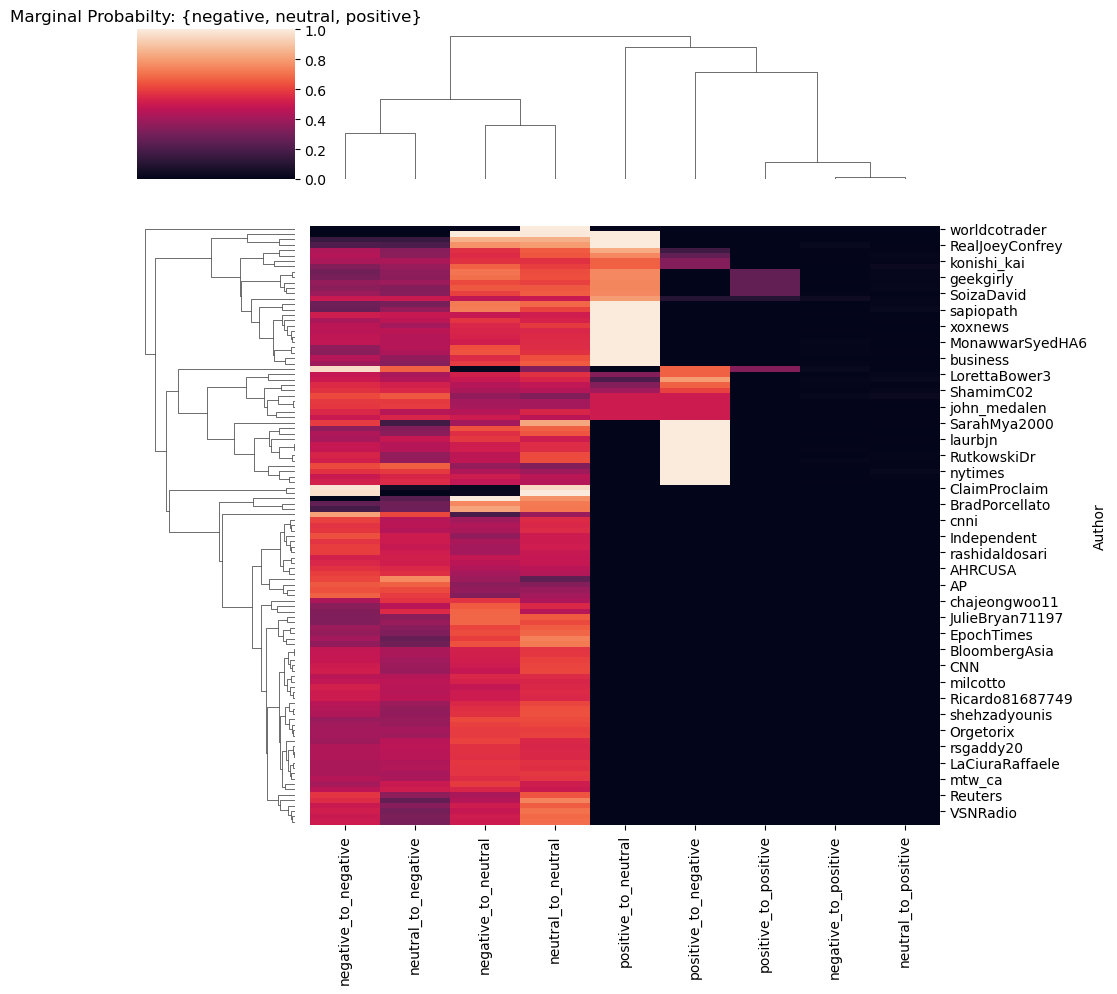

In [22]:
# fig, ax = plt.subplots(figsize=(15,12))
sns.clustermap(marginal_df.fillna(0))#, cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.title(f"Marginal Probabilty: {{{sentiment_titles}}}")
plt.tight_layout()
plt.savefig(f"{output_figures_dir}/Marginal_Probability_Clusterplot_def_{sentiments}.png")
plt.show()

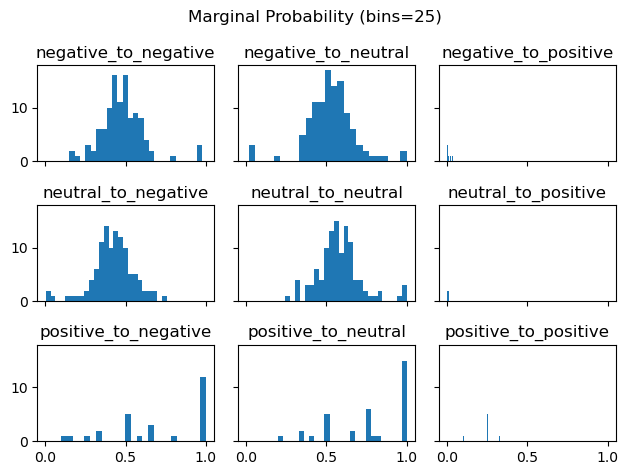

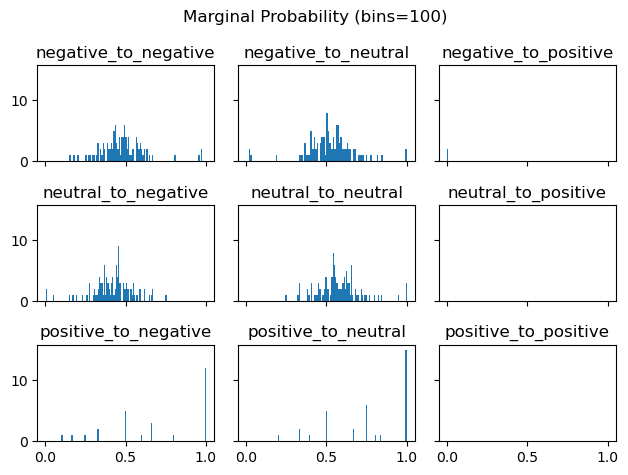

In [23]:
for binv in [25, 100]:
    fig, axs = plt.subplots(num_sentiments, num_sentiments, sharey=True, sharex=True)
    for idx, col in enumerate(marginal_df.columns):
        y = idx % num_sentiments
        x = idx // num_sentiments
        marginal_df[col].hist(bins=binv, ax=axs[x][y])
        axs[x][y].set_title(col)
        axs[x][y].grid(False)
    
    plt.suptitle(f"Marginal Probability (bins={binv})")
    
    plt.tight_layout()
    plt.savefig(f"{output_figures_dir}/MarginalProbsHistograms_{sentiments}_bins{binv}.png")
    plt.show()

## 5. Transitions over time

In [24]:
def transition_time_calc(df):
    df["Transitions"] = df["NumericSentiment"].diff()
    df.dropna(inplace=True)
    df["Trans"] = df[["NumericSentiment", "Transitions"]].apply(lambda row: fdiff_to_transition[row["Transitions"]] if row["Transitions"] in fdiff_to_transition else numeric_to_echo_transitions[row["NumericSentiment"]], axis=1)
    return df.drop(columns=["Author","NumericSentiment","Transitions"]).set_index("Date")
    
transition_times = datadf[["Author", "Date", "NumericSentiment"]].groupby("Author").apply(lambda gdf: transition_time_calc(gdf)).reset_index()
transition_times

,Author,Date,Trans
0,2023Jamesthai,2023-10-07 12:35:03,negative_to_neutral
1,2023Jamesthai,2023-10-07 12:36:22,negative_to_negative
2,2023Jamesthai,2023-10-07 12:36:49,neutral_to_negative
3,2023Jamesthai,2023-10-07 12:51:46,negative_to_neutral
4,2023Jamesthai,2023-10-07 13:34:52,negative_to_negative
...,...,...,...
35142,zerohedge,2023-10-16 23:15:09,neutral_to_negative
35143,zerohedge,2023-10-18 01:57:32,neutral_to_neutral
35144,zerohedge,2023-10-18 19:36:11,neutral_to_neutral
35145,zerohedge,2023-10-18 23:15:52,neutral_to_neutral


In [25]:
transition_times_datafile = transition_times.set_index("Date").sort_index()
transition_times_datafile.to_csv(f"{output_dir}/transition_times_{sentiments}.csv")
transition_times_datafile

,Author,Trans
Date,,
2023-10-06 06:21:36,ArtVandelay2021,negative_to_negative
2023-10-06 09:00:08,Reuters,neutral_to_neutral
2023-10-06 12:15:03,AJEnglish,neutral_to_neutral
2023-10-06 12:17:07,ArtVandelay2021,negative_to_negative
2023-10-06 18:12:13,ArtVandelay2021,negative_to_negative
...,...,...
2023-10-20 23:57:37,dcexaminer,negative_to_neutral
2023-10-20 23:58:06,BaronianConsult,neutral_to_neutral
2023-10-20 23:58:21,BaronianConsult,negative_to_neutral


## 5.1 Separate Matrices

In [26]:
transition_times_datafile.index.min(), transition_times_datafile.index.max()

(Timestamp('2023-10-06 06:21:36'), Timestamp('2023-10-20 23:59:25'))

In [27]:
def foo(df):
    return df.shape[0]
    
date_trans_count_df = transition_times_datafile.groupby([pd.Grouper(freq="1H"), "Trans"]).apply(lambda gdf: foo(gdf))
date_trans_count_df

Date                 Trans               
2023-10-06 06:00:00  negative_to_negative     1
2023-10-06 09:00:00  neutral_to_neutral       1
2023-10-06 12:00:00  negative_to_negative     1
                     neutral_to_neutral       1
2023-10-06 18:00:00  negative_to_negative     1
                                             ..
2023-10-20 22:00:00  neutral_to_neutral      32
2023-10-20 23:00:00  negative_to_negative     5
                     negative_to_neutral     11
                     neutral_to_negative      8
                     neutral_to_neutral      27
Length: 1517, dtype: int64

In [28]:
start_datetime = transition_times_datafile.index.min()
start_datetime

Timestamp('2023-10-06 06:21:36')

In [29]:
start_date = start_datetime.date()
start_date

datetime.date(2023, 10, 6)

In [30]:
end_datetime = transition_times_datafile.index.max()
end_datetime

Timestamp('2023-10-20 23:59:25')

In [31]:
end_date = (end_datetime + datetime.timedelta(days=1)).date()
end_date

datetime.date(2023, 10, 21)

In [32]:
date_trans_count_df.rename("Count").reset_index().to_csv(f"{output_dir}/Date_Trans_Count_{sentiments}.csv", index=False)

In [33]:
def bar(df):
    # print(df)
    return df.groupby("Author").size()

for trans in transition_times_datafile["Trans"].unique():
    print(trans)
    y = transition_times_datafile[transition_times_datafile["Trans"] == trans].resample("1H").apply(lambda gdf: bar(gdf)).rename("Count").reset_index()
    y.pivot(columns="Author", values="Count", index="Date").fillna(0).reindex(pd.date_range(start_date, end_date, freq="1H"), fill_value=0).T.to_csv(f"{output_dir}/Author_Counts_overtime_for_{trans}_in_{sentiments}.csv")

negative_to_negative
neutral_to_neutral
neutral_to_negative
negative_to_neutral
positive_to_negative
negative_to_positive
neutral_to_positive
positive_to_neutral
positive_to_positive
